**About** : This notebook is used to infer models.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/workspace/kaggle_rsna_abdominal/src


### Imports

In [3]:
# !pip install -qU python-gdcm pydicom pylibjpeg dicomsdl

In [4]:
import os
import sys
import cv2
import glob
import json
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm

In [5]:
from inference.extract_features import Config
from inference.lvl2 import predict as predict_2
from inference.lvl2 import PatientFeatureInfDataset, to_sub_format
from inference.crop import get_crops

from util.torch import load_model_weights
from util.plots import plot_mask

from data.transforms import get_transfos
from data.dataset import AbdominalCropDataset

from inference.processing import process, restrict_imgs
from inference.lvl1 import predict, AbdominalInfDataset


from model_zoo.models import define_model
from model_zoo.models_lvl2 import define_model as define_model_2
from model_zoo.models_seg import define_model as define_model_seg
from model_zoo.models_seg import convert_3d

### Params

In [6]:
EVAL = False

In [7]:
DATA_PATH = "../input/test_images/"
SAVE_FOLDER = "../output/tmp/"

In [8]:
BATCH_SIZE = 32
BATCH_SIZE_2 = 512
USE_FP16 = True
NUM_WORKERS = 2

RESTRICT = True
HALF = False

In [9]:
# FOLD = 3
# # FOLD = "fullfit_0"

# EXP_FOLDERS = [
#     ("../logs/2023-09-20/14/", "seg", [FOLD]),
#     ("../logs/2023-09-20/36_r/", "probas_2d", [FOLD]),
#     ("../logs/2023-09-27/20_r/", "probas_3d", [FOLD]),  # convnext-tiny rnn 3fs3
# #     ("../logs/2023-09-26/39_r/", "probas_3d", [FOLD]),  # convnext-tiny rnn 2.5D 5fs5
# ]

# CROP_EXP_FOLDERS = [
#     ("../logs/2023-10-02/41/", "crop", [FOLD])
# ]

# EXP_FOLDERS_2 = [
# #     "../logs/2023-10-02/27/"
# #     "../logs/2023-10-02/60/",
#     "../logs/2023-10-03/22/",
# ]

# EXP_FOLDER_3D = "../logs/2023-09-24/20/"


# FOLDS_2 = [0, 1, 2, 3]
# if "fullfit" not in str(FOLD):
#     FOLDS_2 = [FOLD]
    
# # HALF = False
# Config(json.load(open(EXP_FOLDERS_2[0] + "config.json", 'r'))).exp_folders

In [10]:
FOLD = 0
# FOLD = "fullfit_0"
HALF = True

EXP_FOLDERS = [
    ("../logs/2023-09-20/14/", "seg", [FOLD]),
    ("../logs/2023-09-20/36_r/", "probas_2d", [FOLD]),
    ("../logs/2023-10-05/13/", "probas_2d", [FOLD])
]

CROP_EXP_FOLDERS = [
#     ("../logs/2023-10-06/31/", "crop", [FOLD])
    ("../logs/2023-10-02/41/", "crop", [FOLD])
]

EXP_FOLDERS_2 = [
#     "../logs/2023-10-07/24/",  # half
    "../logs/2023-10-07/26/"
]

EXP_FOLDER_3D = "../logs/2023-09-24/20/"


FOLDS_2 = [0, 1, 2, 3]
if "fullfit" not in str(FOLD):
    FOLDS_2 = [FOLD]
    
Config(json.load(open(EXP_FOLDERS_2[0] + "config.json", 'r'))).exp_folders

[['../logs/2023-09-20/14/', 'seg'],
 ['../logs/2023-09-20/36_r/', 'probas_2d'],
 ['../logs/2023-10-05/13/', 'probas_2d'],
 ['../logs/2023-10-02/41/', 'crop']]

In [11]:
# from util.logger import upload_to_kaggle

# to_upload = [p[0] if isinstance(p, tuple) else p for p in EXP_FOLDERS + CROP_EXP_FOLDERS + EXP_FOLDERS_2 + [EXP_FOLDER_3D]]

# upload_to_kaggle(
#     to_upload,
#     "../output/dataset/",
#     "RSNA Abdomen Weights 1",
#     update_folders=True
# )

## Seg & Level 1

In [12]:
class Config3d:
    size = 256
    plot = FOLD == 0
    margin = 5
#     n_frames_to_save = 30

config = Config(json.load(open(EXP_FOLDER_3D + "config.json", "r")))

model_seg = define_model_seg(
    config.decoder_name,
    config.name,
    num_classes=config.num_classes,
    num_classes_aux=config.num_classes_aux,
    n_channels=config.n_channels,
    increase_stride=config.increase_stride,
    pretrained=False,
)

model_seg = convert_3d(model_seg)
model_seg = load_model_weights(model_seg, EXP_FOLDER_3D + f"{config.name}_{FOLD}.pt")
model_seg = model_seg.eval().cuda()


 -> Loading encoder weights from ../logs/2023-09-24/20/resnet18d_0.pt



In [13]:
models = []

for exp_folder, mode, folds in EXP_FOLDERS:
    models_ = []
    config = Config(json.load(open(exp_folder + "config.json", "r")))

    model = define_model(
        config.name,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        use_gem=config.use_gem,
        head_3d=config.head_3d if hasattr(config, "head_3d") else "",
        n_frames=config.n_frames if hasattr(config, "n_frames") else "",
        replace_pad_conv=config.replace_pad_conv,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        reduce_stride=config.reduce_stride,
        increase_stride=config.increase_stride if hasattr(config, "increase_stride") else False,
        pretrained=False
    )
    model = model.cuda().eval()
    
    for fold in folds:
        weights = exp_folder + f"{config.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=config.local_rank == 0)
        models_.append(model)
        
    models.append(models_)


 -> Loading encoder weights from ../logs/2023-09-20/14/efficientnetv2_rw_t_0.pt


 -> Loading encoder weights from ../logs/2023-09-20/36_r/convnextv2_tiny_0.pt


 -> Loading encoder weights from ../logs/2023-10-05/13/maxvit_tiny_tf_384_0.pt



  0%|          | 0/4 [00:00<?, ?it/s]

-> Patient 10082 - Series 8139


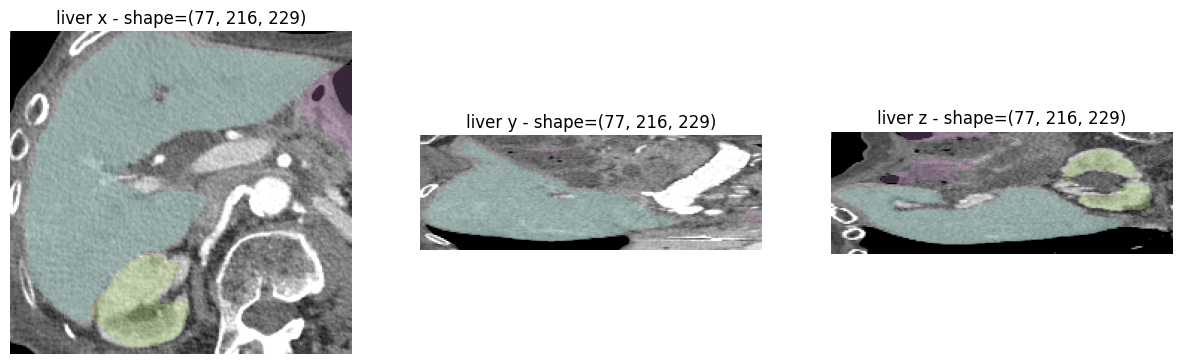

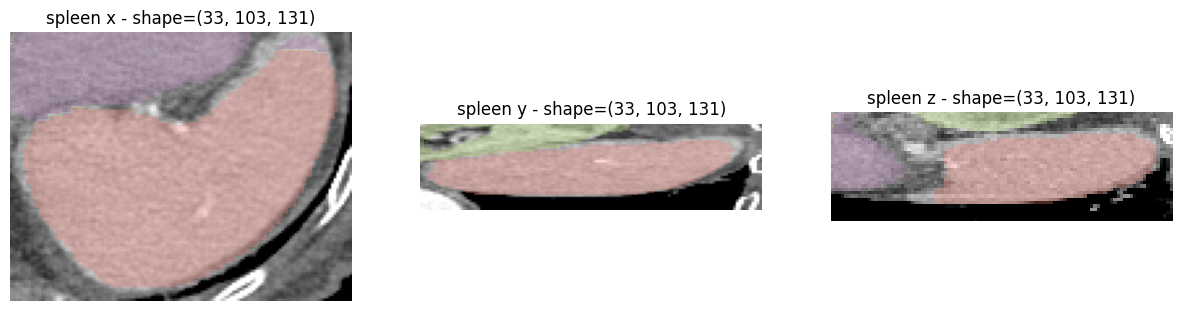

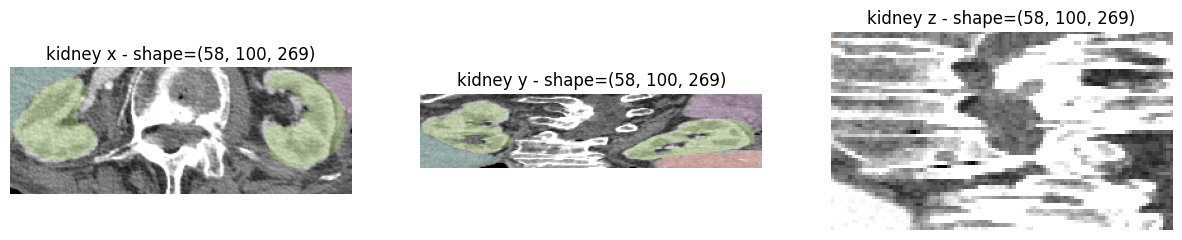

100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


In [14]:
# %%time

dfs = []
for patient in tqdm(sorted(os.listdir(DATA_PATH))):
    if FOLD == 0:
        if EVAL:
            if int(patient) not in patients:
                continue
        else:
            if patient != "10082":
                continue
    elif FOLD == 3:
        if patient != "10004":
            continue

    for series in sorted(os.listdir(DATA_PATH + patient)):
        print("-> Patient", patient, '- Series', series)

        imgs, paths, n_imgs = process(
            patient,
            series,
            data_path=DATA_PATH,
            on_gpu=True,
            crop_size=384,
            restrict=RESTRICT
        )

#         img_paths = sorted(glob.glob(f'../input/imgs/{patient}_{series}*'))
#         if RESTRICT:
#             img_paths, n_imgs = restrict_imgs(img_paths)
#         imgs = np.array([cv2.imread(k, 0).astype(np.float32) / 255 for k in img_paths])
#         imgs = torch.from_numpy(imgs).float().cuda()
#         paths = [k.split('/')[-1] for k in img_paths]

        # Seg & Crop
        with torch.cuda.amp.autocast(enabled=True):
            x = F.interpolate(imgs.unsqueeze(0).unsqueeze(0), size=(Config3d.size, Config3d.size, Config3d.size), mode="nearest")
            pred = model_seg(x)[0].argmax(1, keepdims=True).float()
            pred = F.interpolate(pred, size=(len(imgs), 384, 384), mode="nearest")
            
        seg = pred[0][0]
        coords = get_crops(seg)
#         seg = np.load(EXP_FOLDER + "masks/" + f"mask_{patient}_{series}.npy")

        for (x0, x1, y0, y1, z0, z1), name in zip(coords, ['liver', 'spleen', 'kidney']):
            x0, x1 = max(0, x0 - Config3d.margin), min(imgs.shape[0], x1 + Config3d.margin)
            y0, y1 = max(0, y0 - Config3d.margin), min(imgs.shape[1], y1 + Config3d.margin)
            z0, z1 = max(0, z0 - Config3d.margin), min(imgs.shape[2], z1 + Config3d.margin)

            img_crop = (imgs[x0: x1, y0:y1, z0:z1].cpu().numpy() * 255).astype(np.uint8)
            
# #             crop_ref = np.load("../input/crops/imgs/" + f'{patient}_{series}_{name}.npy') / 255.
# #             print(img_crop.shape, crop_ref.shape, np.abs(img_crop - crop_ref).max())

            if Config3d.plot:
                seg_crop = seg[x0: x1, y0:y1, z0:z1].cpu().numpy()
        
                plt.figure(figsize=(15, 5))
                plt.subplot(1, 3, 1)
                id_ = img_crop.shape[0] // 2
                plot_mask(img_crop[id_], seg_crop[id_])
                plt.title(f'{name} x - shape={img_crop.shape}')
                plt.subplot(1, 3, 2)
                id_ = img_crop.shape[1] // 2
                plot_mask(img_crop[:, id_], seg_crop[:, id_])
                plt.title(f'{name} y - shape={img_crop.shape}')
                plt.subplot(1, 3, 3)
                id_ = img_crop.shape[2] // 2
                plot_mask(img_crop[:, :, id_], seg_crop[:, :, id_])
                plt.title(f'{name} z - shape={img_crop.shape}')
                plt.show()

#             if len(img_crop) > Config3d.n_frames_to_save + 2:
#                 mid = len(img_crop) // 2
#                 img_crop_save = img_crop[mid - Config3d.n_frames_to_save // 2: mid + Config3d.n_frames_to_save // 2].copy()
# #                     print(mid - Config3d.n_frames_to_save // 2, mid + Config3d.n_frames_to_save // 2, img_crop.shape)
#             else:
            img_crop_save = img_crop.copy()
            np.save(SAVE_FOLDER + f'{patient}_{series}_{name}.npy', img_crop_save)
# #                 np.save(SAVE_FOLDER_MASK + f'{df_series.patient_id[i]}_{df_series.series[i]}_{name}.npy', seg_crop)

        # Cls
        df = pd.DataFrame({"path": paths})
        df['patient_id'] = df['path'].apply(lambda x: x.split('_')[0])
        df['patient'] = df['path'].apply(lambda x: x.split('_')[0])
        df['series'] = df['path'].apply(lambda x: x.split('_')[1])
        df['frame'] = df['path'].apply(lambda x: int(x.split('_')[2][:-4]))
        dfs.append(df)

        for models_list, (exp_folder, _, _) in zip(models, EXP_FOLDERS):
            exp_name = "_".join(exp_folder.split('/')[-2:-1])
            if "2023" not in exp_name:  # locally
                exp_name = "_".join(exp_folder.split('/')[-3:-1])
            
            config = Config(json.load(open(exp_folder + "config.json", "r")))
            
            transfos = get_transfos(
                augment=False,
                resize=(384, 384),
                crop=True
            )

            preds = []
            is_3d = config.head_3d if hasattr(config, "head_3d") else False
            if is_3d:
                for model in models_list:
                    model.set_mode("img")

                    dataset = AbdominalInfDataset(
                        df,
                        transforms=transfos,
                        frames_chanel=config.frames_chanel,
                        n_frames=config.n_frames,
                        stride=config.stride,
                        imgs=imgs,
                        paths=paths,
                    )

                    features = predict(
                        model,
                        dataset,
                        {"activation": "none"},
                        batch_size=BATCH_SIZE,
                        use_fp16=USE_FP16,
                        num_workers=0,
                    )

                    model.set_mode("ft")

                    dataset = AbdominalInfDataset(
                        df,
                        transforms=transfos,
                        frames_chanel=config.frames_chanel,
                        n_frames=config.n_frames,
                        stride=config.stride,
                        features=features,
                    )

                    pred = predict(
                        model,
                        dataset,
                        config.loss_config,
                        batch_size=512,
                        use_fp16=USE_FP16,
                        num_workers=NUM_WORKERS,
                    )
                    preds.append(pred)

            else:
                dataset = AbdominalInfDataset(
                    df,
                    transforms=transfos,
                    frames_chanel=config.frames_chanel if hasattr(config, "frames_chanel") else 0,
                    n_frames=config.n_frames if hasattr(config, "n_frames") else 1,
                    stride=config.stride if hasattr(config, "stride") else 1,
                    imgs=imgs,
                    paths=paths,
                )
                if HALF:
                    dataset.info = dataset.info[::2]

                for model in models_list:
                    pred = predict(
                        model,
                        dataset,
                        config.loss_config,
                        batch_size=BATCH_SIZE,
                        use_fp16=USE_FP16,
                        num_workers=0,
                    )
#                     print(pred.shape)
                    if HALF:
                        pred = np.repeat(pred, 2, axis=0)[:len(df)]
#                     print(pred.shape)
                    preds.append(pred)

            if RESTRICT:
                pred_padded = np.zeros((n_imgs, pred.shape[-1]))
                pred_padded[-len(pred):] = np.mean(preds, 0)
            else:
                pred_padded = np.mean(preds, 0)

            np.save(SAVE_FOLDER + f"{series}_{exp_name}.npy", pred_padded)
            
            if FOLD == 0 and not RESTRICT:
                ref = np.load(exp_folder + "pred_val_0.npy")
                ref = ref[:len(pred)]
                
                plt.plot(ref - np.mean(preds, 0))
                plt.title(np.abs(ref - np.mean(preds, 0)).max())
                plt.show()

#             break
#     break

df = pd.concat(dfs, ignore_index=True)
df = df.groupby(['patient', 'series']).max().reset_index()

## Crop models

In [15]:
df_series = pd.DataFrame({"img_path": sorted(glob.glob(SAVE_FOLDER + f'*.npy'))})
df_series['patient_id'] = df_series['img_path'].apply(lambda x: x.split('/')[-1].split('_')[0])
df_series['series'] = df_series['img_path'].apply(lambda x: x.split('_')[-2])
df_series['organ'] = df_series['img_path'].apply(lambda x: x.split('_')[-1][:-4])

df_series['target'] = 0
df_series = df_series[df_series['organ'].isin(['kidney', 'liver', 'spleen'])].reset_index(drop=True)

if FOLD == 0:
    df_series = df_series[df_series['patient_id'].astype(int) == 10082].reset_index(drop=True)
elif FOLD == 3:
    df_series = df_series[df_series['patient_id'].astype(int) == 10004].reset_index(drop=True)

In [16]:
crop_fts = []
for exp_folder, mode, folds in CROP_EXP_FOLDERS:
    
    config = Config(json.load(open(exp_folder + "config.json", "r")))

    model = define_model(
        config.name,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        use_gem=config.use_gem,
        head_3d=config.head_3d if hasattr(config, "head_3d") else "",
        n_frames=config.n_frames if hasattr(config, "n_frames") else "",
        replace_pad_conv=config.replace_pad_conv,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        reduce_stride=config.reduce_stride,
        increase_stride=config.increase_stride if hasattr(config, "increase_stride") else False,
        pretrained=False
    )
    model = model.cuda().eval()
    
    preds = []
    for fold in folds:
        weights = exp_folder + f"{config.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=config.local_rank == 0)
        
        transfos = get_transfos(
            augment=False, resize=config.resize, crop=config.crop
        )

        dataset = AbdominalCropDataset(
            None,
            None,
            transforms=transfos,
            frames_chanel=config.frames_chanel,
            n_frames=config.n_frames,
            stride=config.stride,
            use_mask=config.use_mask,
            train=False,
            df_series=df_series
        )

        pred = predict(
            model,
            dataset,
            config.loss_config,
            batch_size=BATCH_SIZE,
            use_fp16=USE_FP16,
            num_workers=NUM_WORKERS,
        )
        preds.append(pred)

    preds = np.mean(preds, 0)
    crop_fts.append(preds)
    
crop_fts = np.array(crop_fts) # n_models x 3*n_studies x n_classes
np.save(SAVE_FOLDER + "crop_fts.npy", crop_fts)


 -> Loading encoder weights from ../logs/2023-10-02/41/coatnet_1_rw_224_0.pt



In [17]:
crop_fts = np.load(SAVE_FOLDER + "crop_fts.npy")

crop_fts = crop_fts.reshape(crop_fts.shape[0], crop_fts.shape[1] // 3, 3, crop_fts.shape[2])  # n_models x n_studies x n_organs x 3
crop_fts = crop_fts.transpose(1, 2, 3, 0)  # n_studies x n_organs x 3 x n_models
crop_fts = crop_fts.reshape(crop_fts.shape[0], crop_fts.shape[1], crop_fts.shape[2] * crop_fts.shape[3])  # n_studies x n_organs x 3 * n_models

In [18]:
# crop_fts

In [19]:
# (crop_fts - np.array(
#     [[[9.94628906e-01, 4.81796265e-03, 7.89165497e-04],
#     [9.96582031e-01, 2.68936157e-03, 7.21931458e-04],
#     [8.11035156e-01, 1.51489258e-01, 3.75366211e-02]],
#     [[9.93652344e-01, 5.71060181e-03, 7.65800476e-04],
#     [9.96582031e-01, 2.56729126e-03, 6.94274902e-04],
#     [9.68750000e-01, 1.92565918e-02, 1.19247437e-02]]]
# )).max()

## Level 2

In [20]:
all_preds = []

for exp_folder in EXP_FOLDERS_2:
    config_2 = Config(json.load(open(exp_folder + "config.json", "r")))

    dataset = PatientFeatureInfDataset(
        df['series'],
        config_2.exp_folders,
        crop_fts=crop_fts,
        max_len=config_2.max_len,
        restrict=config_2.restrict,
        resize=config_2.resize,
        save_folder=SAVE_FOLDER,
        half=True,
    )
    
    model = define_model_2(
        config_2.name,
        ft_dim=config_2.ft_dim,
        layer_dim=config_2.layer_dim,
        n_layers=config_2.n_layers,
        dense_dim=config_2.dense_dim,
        p=config_2.p,
        use_msd=config_2.use_msd,
        num_classes=config_2.num_classes,
        num_classes_aux=config_2.num_classes_aux,
        n_fts=config_2.n_fts,
    )
    model = model.eval().cuda()

    for fold in FOLDS_2:
        weights = exp_folder + f"{config_2.name}_{fold}.pt"
        model = load_model_weights(model, weights, verbose=config.local_rank == 0)
    
        preds = predict_2(
            model,
            dataset,
            config_2.loss_config,
            batch_size=BATCH_SIZE_2,
            use_fp16=USE_FP16,
            num_workers=NUM_WORKERS,
        )
        all_preds.append(preds)


 -> Loading encoder weights from ../logs/2023-10-07/26/rnn_att_0.pt



In [21]:
preds = np.mean(all_preds, 0).astype(np.float64)

for i in range(preds.shape[1]):
    df[f'pred_{i}'] = preds[:, i]

dfg = df.drop(['series', 'path', 'frame', 'patient_id'], axis=1).groupby('patient').mean().reset_index()
sub = to_sub_format(dfg)

sub

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,10082,0.996393,0.003607,0.873901,0.126099,0.987305,0.010353,0.002155,0.974609,0.023422,0.002098,0.966309,0.026779,0.006718


### Checks

In [22]:
df_oof = pd.read_csv(exp_folder + 'df_oof.csv')
df_oof = df_oof[df_oof['patient_id'].isin(sub['patient_id'].values.astype(int))]

df_oof = df_oof[["patient_id", "fold"] + list(df_oof.columns[-11:])]
df_oof.columns = ["patient_id", "fold", "bowel_injury", "extravasation_injury"] + list(sub.columns[-9:])
df_oof["extravasation_healthy"] = 1 - df_oof["extravasation_injury"]
df_oof["bowel_healthy"] = 1 - df_oof["bowel_injury"]

df_oof = df_oof.sort_values('patient_id', ignore_index=True)

df_oof['diff'] = (sub[sub.columns[1:]] - df_oof[sub.columns[1:]]).abs().max(1)

df_oof = df_oof[list(sub.columns) + ['fold', 'diff']]
# df_oof[df_oof['fold'] == FOLD]
df_oof

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,fold,diff
0,10082,0.996365,0.003635,0.873169,0.126831,0.987305,0.010323,0.002151,0.974121,0.02359,0.002115,0.96582,0.027161,0.006821,0,0.000732


In [23]:
# sub.to_csv(SAVE_FOLDER + "submission.csv", index=False)
# sub

Done ! 